In [1]:
import logging
import numpy as np
import pandas as pd
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Распечатайте подробный отчет о классификации.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Выберите некоторое количество функций, используя критерий chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Выведите десять наиболее отличительных терминов для каждого класса."
                   " Для каждого классификатора.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Использовать ли все категории или нет.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Распечатайте подробный отчет о классификации.
  --chi2_select=SELECT_CHI2
                        Выберите некоторое количество функций, используя
                        критерий chi-squared test
  --confusion_matrix    Print the confusion matrix.
  --top10               Выведите десять наиболее отличительных терминов для
                        каждого класса. Для каждого классификатора.
  --all_categories      Использовать ли все категории или нет.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



## **Load data from the training set**

In [3]:
path_root = Path('/home/owl/PycharmProjects/Questions_search_task')
work_dataset = pd.read_csv(path_root / 'dataset_of_questions' /'work_dataset.csv', sep='\t')
work_dataset = work_dataset.drop('Unnamed: 0', axis=1)
work_dataset.rename(columns={'Line informatation': 'line_information'}, inplace=True)


def class_return(sign):
    return 1 if sign == '?' else 0


work_dataset['label'] = work_dataset['Sign'].apply(class_return)

In [4]:
if opts.all_categories:
    categories = None
else:
    categories = ['question_sentences', 'other_sentences']

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

data_train, data_test, y_train, y_test = train_test_split(work_dataset, 
                                                          work_dataset['label'], 
                                                          test_size=0.3,
                                                          shuffle=True, 
                                                          random_state=42)

print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.label


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.line_information)
data_test_size_mb = size_mb(data_test.line_information)

print(f'{round(len(data_train.line_information), 3)} documents - {round(data_test_size_mb, 3)}Mb ')
print(f'{round(len(data_test.line_information), 3)} documents - {round(data_test_size_mb, 3)}Mb ')
print(f"{len(target_names)} categories")
print()

# y_train, y_test = data_train.label, data_test.label

print("Извлечение функций из обучающих данных с помощью sparse векторизатора")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.line_information)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
    X_train = vectorizer.fit_transform(data_train.line_information)
    
    
duration = time() - t0
print(f"done in {duration} at {round(data_train_size_mb / duration, 3)}")
print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
print()
# print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
# print("n_samples: %d, n_features: %d" % X_train.shape)


print("Извлечение признаков из тестовых данных с помощью того же векторизатора")
t0 = time()
X_test = vectorizer.transform(data_test.line_information)
duration = time() - t0
print(f"done in {duration} at {round(data_test_size_mb / duration, 3)}")
print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")
print()

# --------------------------------------------------------------------------------

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print(f"Extracting {opts.select_chi2} best features by a chi-squared test")
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

data loaded
744856 documents - 45.827Mb 
319225 documents - 45.827Mb 
744856 categories

Извлечение функций из обучающих данных с помощью sparse векторизатора
done in 8.710905075073242 at 12.3
n_samples: 744856, n_features: 405636

Извлечение признаков из тестовых данных с помощью того же векторизатора
done in 3.2943925857543945 at 13.91
n_samples: 319225, n_features: 405636



## **Benchmark classifiers**

We train and test the datasets with 15 different classification models and get performance results for each model.

*Перевод:*
Мы обучаем и тестируем наборы данных с помощью 15 различных моделей классификации и получаем результаты производительности для каждой модели.

In [6]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f'train tume: {round(train_time, 3)}')

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print(f'accuracy: {round(score, 3)}')

    if hasattr(clf, 'coef_'):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))

#                 print(trim(f"{label}: {" ".join(feature_names[top10]}")) # print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


/home/owl/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train tume: 9.433
test time:  0.010s
accuracy: 0.843
dimensionality: 405636
density: 1.0


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train tume: 2.226
test time:  0.010s
accuracy: 0.806
dimensionality: 405636
density: 0.7177568065950753


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train tume: 6.667
test time:  0.010s
accuracy: 0.829
dimensionality: 405636
density: 0.8499985208413454


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
train tume: 0.053
test time:  4674.006s
accuracy: 0.626

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train tume: 19219.623
test time:  130.837s
accuracy: 0.869

L2 penalty
__________________________

/home/owl/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train tume: 0.175
test time:  0.054s
accuracy: 0.781
dimensionality: 405636
density: 1.0


________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)


/home/owl/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/home/owl/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train tume: 0.139
test time:  0.022s
accuracy: 0.797
dimensionality: 405636
density: 1.0


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
train tume: 11.471
test time:  0.034s
accuracy: 0.851



## **Add plots**

The bar plot indicates the accuracy, training time (normalized) and test time (normalized) of each classifier.

*Перевод:*
Гистограмма показывает точность, время обучения (нормализованное) и время тестирования (нормализованное) каждого классификатора.

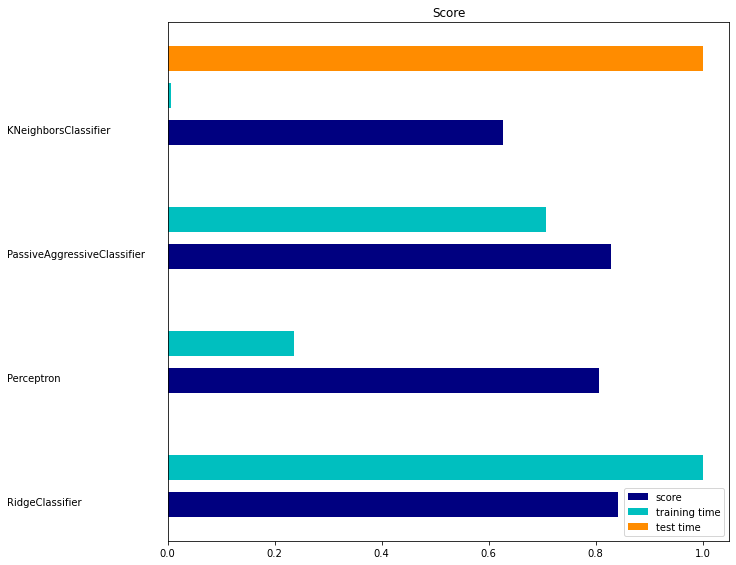

In [16]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()